## DeepXDE求解常微分方程
这个notebook展示了使用DeepXDE求解常微分方程。

1. [一个简单的 ODE 系统](#ODE1)
2. [Lotka-Volterra 方程](#ODE2)
3. [劳伦兹混沌系统 Lorenz Chaos Problem](#ODE3)
4. [一维阻尼谐振子](#ODE4)
5. [周期函数](#ODE5)
6. [ 幂函数](#ODE6)

In [4]:
# 绘图的辅助函数

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    


def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=(10, 6))
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()

<a id="ODE1"></a>
## 一个简单的 ODE 系统

### 问题设置

我们将求解一个简单的 ODE 系统：

$$\large \frac{dy_1}{dt} = y_2 ,\,\,\,\, \frac{dy_2}{dt} = -y_1,\,\,\,\, where \,\,\,\,t∈[0,10],$$



与初始条件 $\large y_1(0)=0,y_2(0)=1.$

参考解决方案是 $$ \large  y_1 = \sin(x) ,\,\,\,\, y_2 = \cos(x).$$

源码：

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/ode_system.py

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.system.html

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



data.PDE

指定几何区域、ODE 和初始条件

In [84]:
def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [1/scale*dy1_x - y2, 1/scale*dy2_x + y1]

def boundary(_, on_initial):
    return on_initial
# def boundary(x, on_initial):
#     return np.isclose(x[0], 0)

def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

In [85]:
scale = 10  # scale是归一化参数，把 (0,scale) 变成 (0,1)
# scale = 10是原问题

geom = dde.geometry.TimeDomain(0, 1.)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

num_domain = 10*scale
num_boundary = 2
num_test = 100*scale

data = dde.data.PDE(geom, ode_system, [ic1, ic2],
                    num_domain=num_domain,
                    num_boundary=num_boundary,
                    num_test=num_test,
                    train_distribution="uniform")

In [86]:
true_data[:1,:]

array([[0., 1.]], dtype=float32)

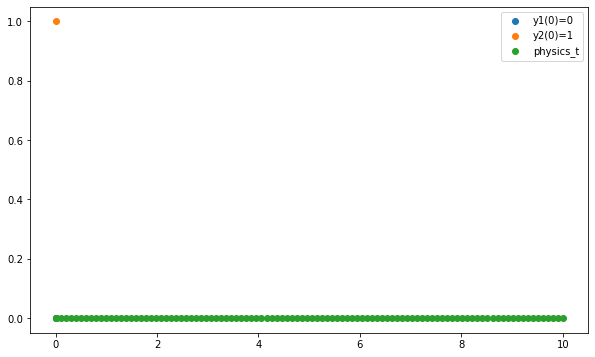

In [87]:
t_list = data.train_next_batch()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list[:1], true_data[:1,0], label="y1(0)=0")
plt.scatter(t_list[:1], true_data[:1,1], label="y2(0)=1")
plt.scatter(t_list, np.zeros(t_list.shape), label="physics_t")
plt.legend()

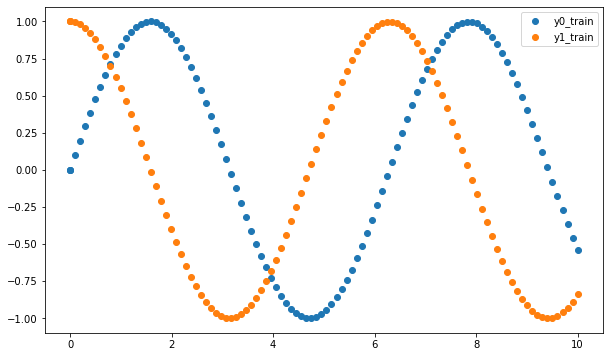

In [88]:
t_list = data.train_next_batch()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list, true_data[:,0], label="y0_train")
plt.scatter(t_list, true_data[:,1], label="y1_train")
plt.legend()

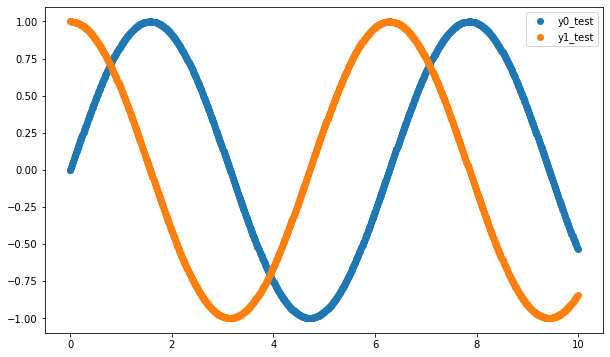

In [89]:
t_list = data.test()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list, true_data[:,0], label="y0_test")
plt.scatter(t_list, true_data[:,1], label="y1_test")
plt.legend()

net

In [90]:
layer_size = [1] + [100] * 3 + [2]
# layer_size = [1,100,500,1000,2]  # 加深加宽网络
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

model

In [91]:
# model.compile("adam", lr=0.001, metrics=["l2 relative error"])
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=20000)
if scale>=20:
    model.compile("adam", lr=2e-5)
    losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.057307 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.426781 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.58e-02, 5.76e-03, 0.00e+00, 1.00e+00]    [4.55e-02, 5.76e-03, 0.00e+00, 1.00e+00]    []  
1000      [8.10e-03, 6.48e-03, 2.51e-06, 2.67e-04]    [8.15e-03, 6.48e-03, 2.51e-06, 2.67e-04]    []  
2000      [4.78e-03, 4.36e-03, 1.82e-08, 1.19e-04]    [4.76e-03, 4.37e-03, 1.82e-08, 1.19e-04]    []  
3000      [2.16e-03, 2.88e-03, 3.29e-06, 3.98e-05]    [2.16e-03, 2.78e-03, 3.29e-06, 3.98e-05]    []  
4000      [7.53e-04, 1.16e-03, 6.88e-06, 2.44e-06]    [7.57e-04, 1.02e-03, 6.88e-06, 2.44e-06]    []  
5000      [2.48e-04, 3.32e-04, 2.77e-06, 2.35e-07]    [2.38e-04, 2.58e-04, 2.77e-06, 2.35e-07]    []  
6000      [2.45e-04, 2.23e-04, 6.19e-05, 3.23e-05]    [2.32e-04, 1.75e-04, 6.19e-05, 3.23e-05]    []  
7000      [4.36e-05, 4.51e-05, 9.00e-09, 9.63e-07]    [3.72e-05, 2.91e-05, 9.00e-09, 9.63e-07]   

plot

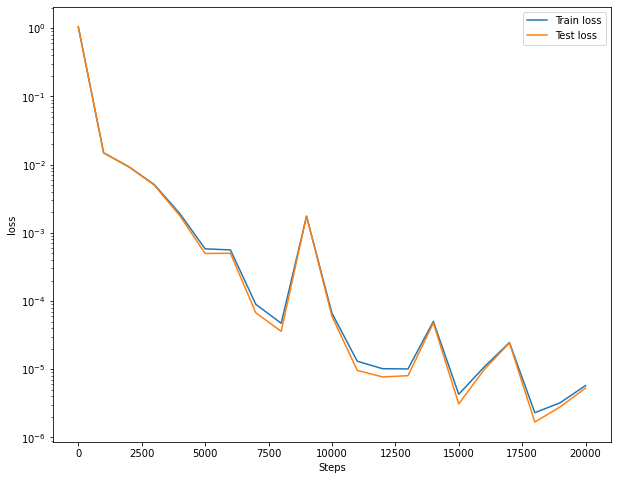

In [92]:
plot_loss_history(losshistory)

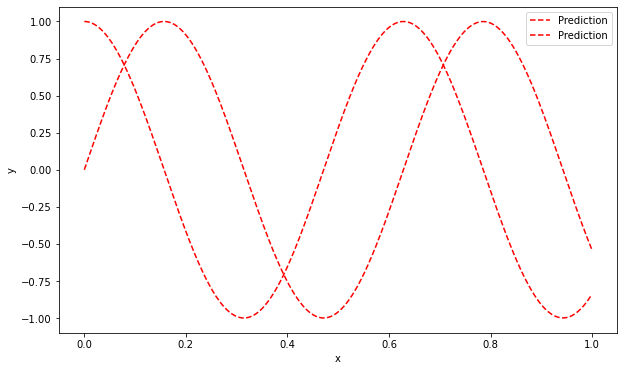

In [93]:
plot_best_state(train_state)

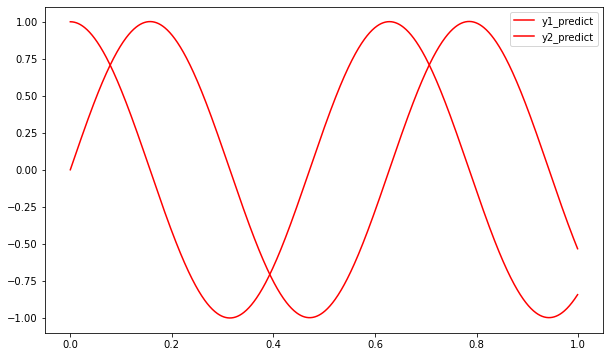

In [94]:
t_list = data.test()[0]
pre_data = model.predict(t_list)
plt.figure(figsize=(10, 6))
plt.plot(t_list, pre_data[:,0], "-r", label="y1_predict")
plt.plot(t_list, pre_data[:,1], "-r", label="y2_predict")
plt.legend()

### 结果展示

scale=1

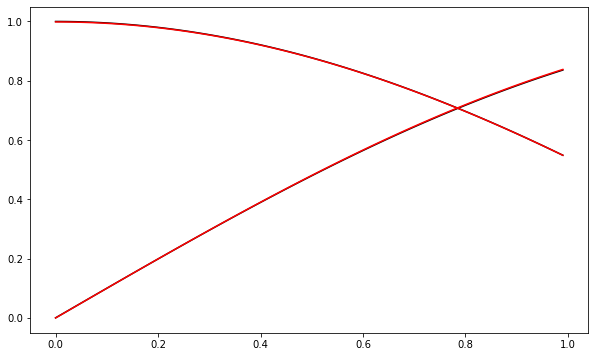

In [83]:
t_list = data.test()[0]*scale  # scale=1
true_data = func(t_list)

pred_data = model.predict(data.test()[0])

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

plt.plot(t_list, pred_data[:,0], "-r", label="Pred")
plt.plot(t_list, pred_data[:,1], "-r", label="Pred")

scale=10

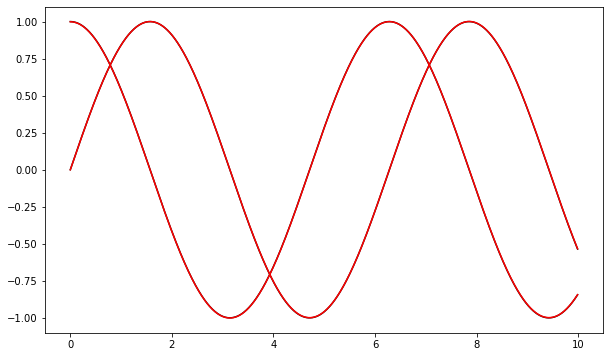

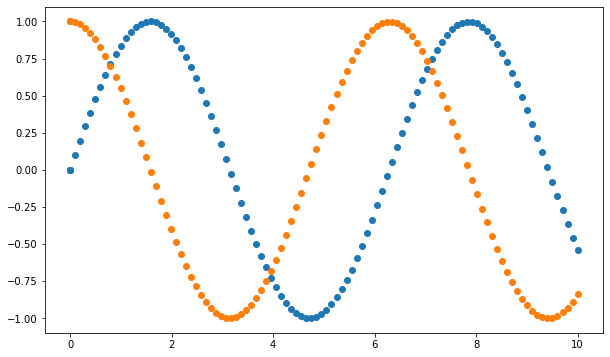

In [95]:
t_list = data.test()[0]*scale  # scale=10
true_data = func(t_list)

pred_data = model.predict(data.test()[0])

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

plt.plot(t_list, pred_data[:,0], "-r", label="Pred")
plt.plot(t_list, pred_data[:,1], "-r", label="Pred")

t_list = data.train_next_batch()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list, true_data[:,0], label="True")
plt.scatter(t_list, true_data[:,1], label="True")

scale=30

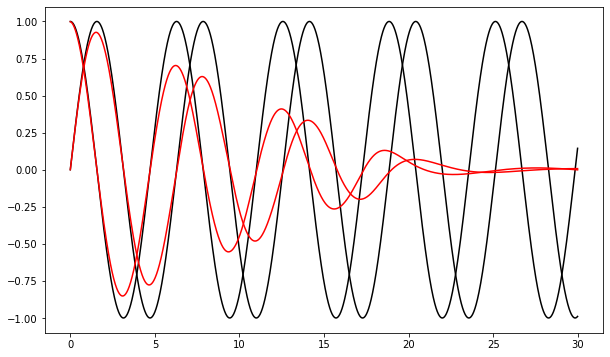

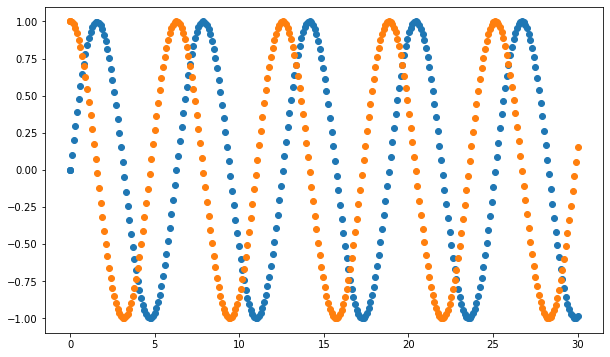

In [71]:
t_list = data.test()[0]*scale  # scale=30
true_data = func(t_list)

pred_data = model.predict(data.test()[0])

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

plt.plot(t_list, pred_data[:,0], "-r", label="Pred")
plt.plot(t_list, pred_data[:,1], "-r", label="Pred")


t_list = data.train_next_batch()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list, true_data[:,0], label="True")
plt.scatter(t_list, true_data[:,1], label="True")

scale=100

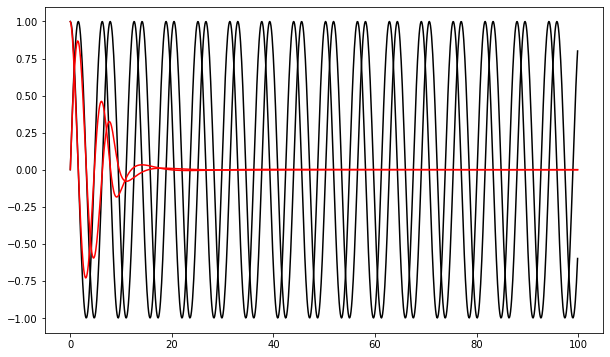

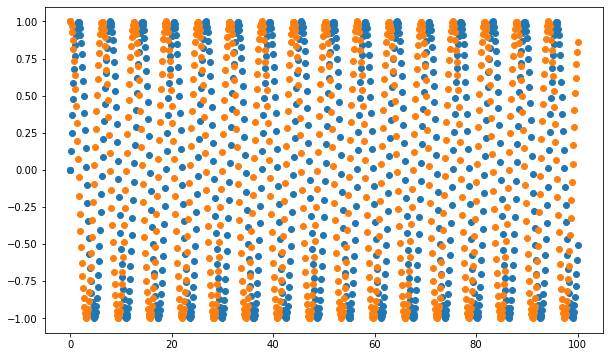

In [136]:
t_list = data.test()[0]*scale  # scale=100
true_data = func(t_list)

pred_data = model.predict(data.test()[0])

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

plt.plot(t_list, pred_data[:,0], "-r", label="Pred")
plt.plot(t_list, pred_data[:,1], "-r", label="Pred")


t_list = data.train_next_batch()[0]*scale
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list, true_data[:,0], label="True")
plt.scatter(t_list, true_data[:,1], label="True")

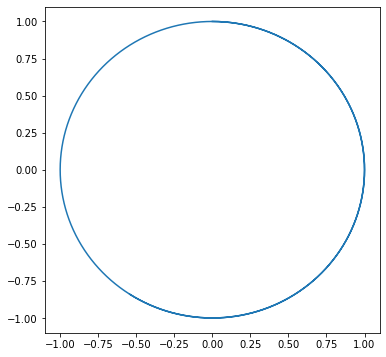

In [50]:
plt.figure(figsize=(6, 6))
plt.plot(true_data[:,0], true_data[:,1])

<a id="ODE2"></a>

# Lotka-Volterra 方程

## 问题设置

我们将求解一个 Lotka-Volterra 方程：
$$
\Large
\begin{cases}
\frac{dr}{dt} &= \frac{R}{U} (2 U r - 0.04 U^2 r p), \\
\frac{dp}{dt} &= \frac{R}{U} (0.02 U^2 r p - 1.06 U p), \\
\end{cases}\\
\large initial\,\,condition: r(0) = \frac{100}{U}, p(0) = \frac{15}{U},\\
\large parameters: U = 200,R=20.\\
$$
第一个参数 $U$ 近似于范围的上限，第二个参数 $R$ 是域的右边界。这两个参数将用于缩放。

参考解决方案是使用`scipy` 的方法`integrate.solve_ivp()`生成的。

### 执行

本描述逐步介绍了上述 Lotka-Volterra 方程的求解器的实现。

首先，导入 DeepXDE、numpy、matplotlib 和 scipy 包：

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



我们首先定义范围的近似上限和域的右边界。稍后，当绘制人口与时间的关系图时，我们通过这些因素进行缩放以获得 0 和 1 之间的图表。

In [3]:
U = 200
R = 20

我们现在定义一个时域。我们通过使用内置类来做到这一点`TimeDomain`：

In [4]:
geom = dde.geometry.TimeDomain(0.0, 1.0)

接下来，我们表达 ODE 系统：

In [5]:
U = 200
R = 20

def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - R/U * (2.0 * U * r - 0.04 * U * U * r * p),
        dp_t - R/U * (0.02 * U * U * r * p - 1.06 * U * p ),
    ]



第一个论点`ode_system`是tt-坐标，由 表示`x`。第二个参数是一个二维向量，表示为`y`，它包含 $r(t)$ 和 $p(t)$.

现在，我们将 ODE 问题定义为

dde.data.PDE参数

dde.data.PDE(geometry, pde, bcs, num_domain=0, num_boundary=0, train_distribution='Sobol', anchors=None, exclusions=None, solution=None, num_test=None, auxiliary_var_function=None)

In [17]:
def boundary(_, on_initial):
    return on_initial

ic1 = dde.icbc.DirichletBC(geom, lambda x: 100/U, boundary, component=0)
ic2 = dde.icbc.DirichletBC(geom, lambda x: 15/U, boundary, component=1)

data = dde.data.PDE(geom, ode_system, [ic1, ic2], 3000, 2, train_distribution='uniform',num_test = 4000)

请注意，在求解这个方程时，我们希望对初始条件有硬约束，因此我们稍后在创建网络时定义它，而不是作为 PDE 的一部分。

我们在域内有 3000 个训练残差点，在边界上有 2 个点。我们使用 3000 个点来测试 ODE 残差。我们现在创建网络：

In [18]:
def func(t, y):
    r, p = y
    dr_t = R/U * (2.0 * U * r - 0.04 * U * U * r * p)
    dp_t = R/U * (0.02 * U * U * r * p - 1.06 * U * p )
    return dr_t, dp_t

# def func(t, r):
#     x, y = r
#     dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
#     dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
#     return dx_t, dy_t

def gen_truedata(t = np.linspace(0, 1, 100)):
    # t = sorted(np.unique(t))
    sol = integrate.solve_ivp(func, (0, 10), (100 / U, 15 / U), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(len(t), 1)
    y_true = y_true.reshape(len(t), 1)

    return x_true, y_true

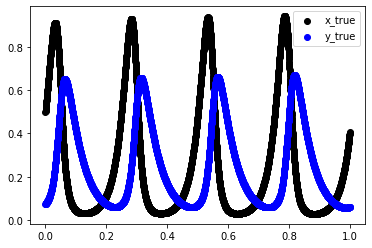

In [19]:
t = data.train_next_batch()[0].flatten()
t = sorted(np.unique(t))

x_true, y_true = gen_truedata(t)
plt.scatter(t, x_true, color="black", label="x_true")
plt.scatter(t, y_true, color="blue", label="y_true")

# plt.plot(t, x_true, color="black", label="x_true")
# plt.plot(t, y_true, color="blue", label="y_true")

plt.legend()
plt.show()

这是一个深度为 7 的神经网络，有 6 个隐藏层，宽度为 50。我们使用 tanh 作为激活函数。

由于我们希望在 Lotka-Volterra 方程中具有周期性行为，因此我们添加了一个特征层 $\sin(kt)$. 这迫使预测是周期性的，因此更准确。


In [20]:
layer_size = [1] + [50] * 3 + [2]
# layer_size = [1,100,150,200,2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

如前所述，我们想要初始条件 $r(0)=100U$ 和 $p(0)=15U$ 是硬约束，所以我们转换输出：

我们添加这些层：

现在我们已经定义了神经网络，我们构建一个`Model`，选择优化器和学习率，并训练它进行 50000 次迭代：

In [21]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.052086 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.406174 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.14e+00, 1.40e+01, 2.38e-01, 7.36e-02]    [1.14e+00, 1.40e+01, 2.38e-01, 7.36e-02]    []  
1000      [3.90e-04, 1.34e-03, 2.49e-01, 6.14e-03]    [3.89e-04, 1.34e-03, 2.49e-01, 6.14e-03]    []  
2000      [8.35e-04, 5.32e-04, 2.48e-01, 5.93e-03]    [8.33e-04, 5.31e-04, 2.48e-01, 5.93e-03]    []  
3000      [1.03e-03, 7.55e-05, 2.48e-01, 5.70e-03]    [1.03e-03, 7.54e-05, 2.48e-01, 5.70e-03]    []  
4000      [1.02e-03, 2.26e-05, 2.48e-01, 5.55e-03]    [1.02e-03, 2.25e-05, 2.48e-01, 5.55e-03]    []  
5000      [9.83e-04, 5.63e-05, 2.48e-01, 5.49e-03]    [9.81e-04, 5.62e-05, 2.48e-01, 5.49e-03]    []  
6000      [1.56e-03, 6.32e-05, 2.48e-01, 5.49e-03]    [1.55e-03, 6.30e-05, 2.48e-01, 5.49e-03]    []  
7000      [9.61e-04, 6.96e-05, 2.48e-01, 5.48e-03]    [9.59e-04, 6.94e-05, 2.48e-01, 5.48e-03]   

在与 Adam 训练之后，我们继续使用 L-BFGS 以获得更小的损失：

In [22]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.246038 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
20000     [9.44e-04, 6.88e-05, 2.48e-01, 5.48e-03]    [9.41e-04, 6.86e-05, 2.48e-01, 5.48e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.254553
  Number of iterations: 4
  Number of functions evaluations: 38
20038     [9.59e-04, 6.99e-05, 2.48e-01, 5.47e-03]    [9.56e-04, 6.97e-05, 2.48e-01, 5.47e-03]    []  

Best model at step 20038:
  train loss: 2.55e-01
  test loss: 2.55e-01
  test metric: []

'train' took 0.634173 s



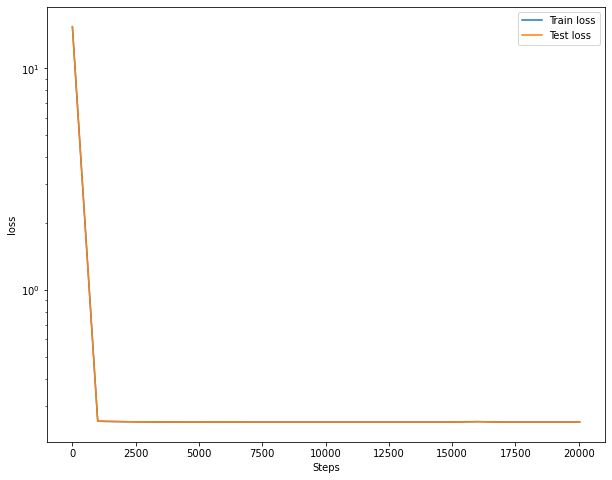

In [23]:
plot_loss_history(losshistory)

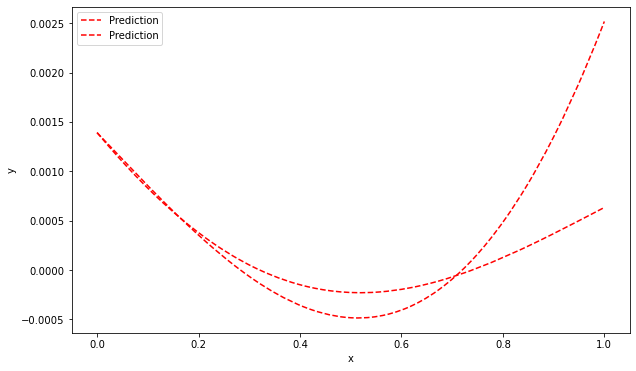

In [24]:
plot_best_state(train_state)

获取真实解

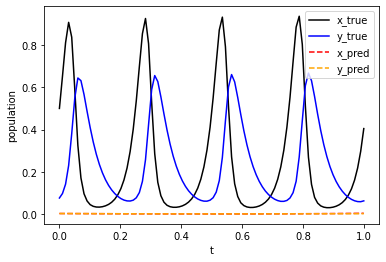

In [25]:
plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata(t)
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

<a id="ODE3"></a>
## 劳伦兹混沌系统 Lorenz Chaos Problem
### 问题设置

我们将求解一个简单的 ODE 系统：

$$
\large
\begin{cases}
\frac{dx}{dt} = \sigma(y-x), \\
\frac{dy}{dt} = \rho x - y - x z, \\
\frac{dz}{dt} = x y - \beta z, \\
\end{cases}\\
\large \sigma = 10,\beta = 8/3,\rho = 28, t \in [0,500]
$$

与初始条件 $\large x(0)=10^{-5},y(0)=0,z(0)=0.$

In [2]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [14]:
sigma = 10
beta = 8./3
rho = 28

def ode_system(t, y_list):
    """ODE system.
    t = (t),y_list = (x,y,z)
    """
    x, y, z = y_list[:, 0:1], y_list[:, 1:2], y_list[:, 2:]
    dx_t = dde.grad.jacobian(y_list, t, i=0)
    dy_t = dde.grad.jacobian(y_list, t, i=1)
    dz_t = dde.grad.jacobian(y_list, t, i=2)
    return [scale*dx_t-sigma*(y-x), scale*dy_t-rho*x+y+x*z, scale*dz_t-x*y+beta*z]

def boundary(_, on_initial):
    return on_initial

In [15]:
scale =  500

geom = dde.geometry.TimeDomain(0., 1.)
ic1 = dde.icbc.IC(geom, lambda x: 1e-5, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)


num_domain = 60*scale
num_boundary = 3
num_test = 60*scale

# data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3],
#                     num_domain=num_domain,
#                     num_boundary=num_boundary,
#                     num_test=num_test,
#                     train_distribution="pseudo")

data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3],
                    num_domain=num_domain,
                    num_boundary=num_boundary,
                    num_test=num_test,
                    train_distribution="uniform")

In [16]:
data.train_next_batch()[0].shape

(30006, 1)

In [17]:
layer_size = [1] + [100] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [18]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.079539 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.614970 s



In [19]:
losshistory, train_state = model.train(epochs=20000)

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.38e+03, 1.54e+04, 1.56e+04, 1.00e-10, 0.00e+00, 0.00e+00]    [2.38e+03, 1.54e+04, 1.56e+04, 1.00e-10, 0.00e+00, 0.00e+00]    []  
1000      [8.98e-03, 4.13e-03, 4.58e-03, 2.99e-03, 2.29e-03, 1.35e-03]    [8.97e-03, 4.13e-03, 4.58e-03, 2.99e-03, 2.29e-03, 1.35e-03]    []  
2000      [2.22e-03, 6.20e-04, 1.78e-03, 1.60e-03, 1.02e-03, 5.36e-04]    [2.22e-03, 6.20e-04, 1.78e-03, 1.60e-03, 1.02e-03, 5.36e-04]    []  
3000      [4.52e-04, 1.01e-05, 5.45e-04, 6.35e-04, 1.04e-04, 3.95e-05]    [4.51e-04, 1.01e-05, 5.45e-04, 6.35e-04, 1.04e-04, 3.95e-05]    []  
4000      [1.75e-04, 5.35e-07, 3.11e-04, 1.05e-04, 1.09e-05, 2.61e-07]    [1.75e-04, 5.35e-07, 3.11e-04, 1.05e-04, 1.09e-05, 2.61e-07]    []  
5000      [6.32e-05, 2.86e-05, 5.57e-05, 1.10e-05, 4.51e-06, 5.34e-09]    [6.32e-05, 2.86e

In [9]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.344767 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
20000     [2.13e-06, 1.84e-06, 5.00e-08, 3.60e-06, 4.83e-09, 3.20e-10]    [2.12e-06, 1.83e-06, 5.00e-08, 3.60e-06, 4.83e-09, 3.20e-10]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 79
  Number of functions evaluations: 96
20096     [2.97e-08, 8.44e-08, 7.12e-08, 3.46e-08, 1.23e-08, 1.29e-11]    [2.96e-08, 8.41e-08, 7.10e-08, 3.46e-08, 1.23e-08, 1.29e-11]    []  

Best model at step 15000:
  train loss: 1.82e-07
  test loss: 1.82e-07
  test metric: []

'train' took 2.374596 s



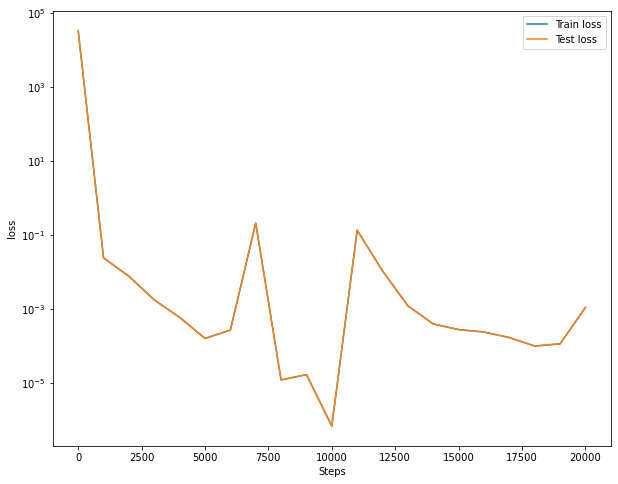

In [20]:
plot_loss_history(losshistory)

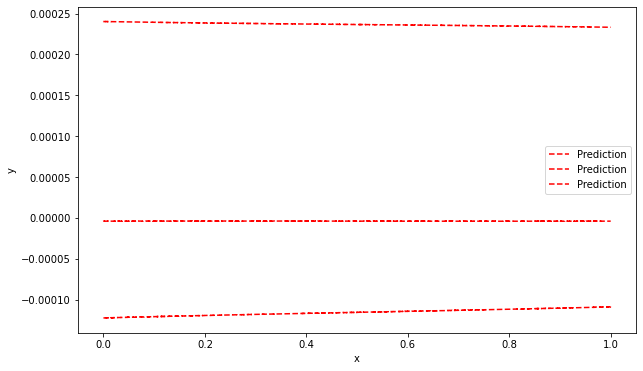

In [21]:
plot_best_state(train_state)

In [22]:
pre_data = _pack_data(train_state)[2]
# pre_data = model.predict(data.test()[0])

pre_data

array([[ 2.40307287e-04, -1.22475205e-04, -4.07922198e-06],
       [ 2.40307287e-04, -1.22475205e-04, -4.07922198e-06],
       [ 2.40307287e-04, -1.22475205e-04, -4.07922198e-06],
       ...,
       [ 2.33246785e-04, -1.09008513e-04, -4.01478610e-06],
       [ 2.33240891e-04, -1.08970795e-04, -4.00931458e-06],
       [ 2.33243612e-04, -1.08958920e-04, -4.02616570e-06]], dtype=float32)

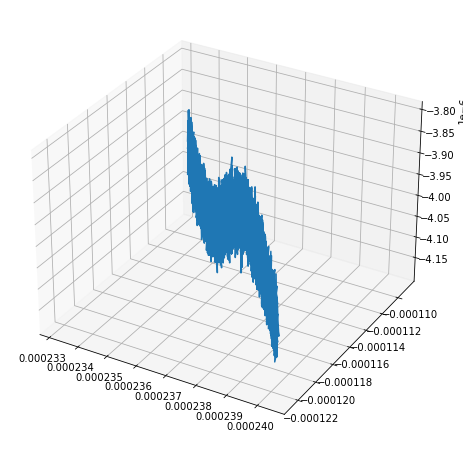

In [23]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
# ax.scatter3D(pre_data[:,0], pre_data[:,1],pre_data[:,2])
ax.plot3D(pre_data[:,0], pre_data[:,1],pre_data[:,2])

<a id="ODE4"></a>
## 一维阻尼谐振子

### 问题概述

我们在这里解决的例子是一维阻尼谐振子:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
或者
$$
\dfrac{d^2 x}{d t^2} + \dfrac{\mu}{m} \dfrac{d x}{d t} + \dfrac{k}{m}x = 0~,
$$
与初始条件
$$
x(0) = 1~~,~~\left. \frac{d x}{d t}\right|_{t=0} = 0~.
$$
我们将着重于解决欠阻尼状态的问题，即当
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.\mu = 2m\delta, \dfrac{k}{m} =  \omega_0^2.
$$
这里有以下精确解:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~, \phi=\arctan(-\frac{\delta}{\omega}), A=\frac{1}{2\cos(\phi)}.
$$

对于这个问题，我们使用 $m=1, \delta = 2 $，$\omega_0 = 20 $，并在 $t\in[0,1]$ 中学习求解问题。

In [65]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

dde.config.set_default_float(value="float32")

m = 1.
delta = 2.
omega_0 = 20.

mu = 2*m*delta
k = m*omega_0*omega_0
omega = np.sqrt(omega_0**2-delta**2)
phi = np.arctan(-delta/omega)
A = 1/(2*np.cos(phi))


def pde(t, x):
    dx_t = dde.grad.jacobian(x, t)
    dx_tt = dde.grad.hessian(x, t)
    # return m*dx_tt + mu*dx_t + k*x
    return dx_tt + mu/m*dx_t + k/m*x


def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def func(t):
    # omega = np.sqrt(omega_0**2-delta**2)
    # phi = np.arctan(-delta/omega)
    # A = 1/(2*np.cos(phi))
    return np.exp(-delta*t)*2*A*np.cos(omega*t+phi)

scale = 1  # [0, 1*scale]

geom = dde.geometry.TimeDomain(0., scale*1)
ic_1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.
# ic_2 = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0.*x, boundary, component=0) # 导数条件 dx(0)/dt = 0

ic_2 = dde.icbc.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x),
    boundary,
) # 导数条件 dx(0)/dt = 0


# observe_x = geom.uniform_points(50)
# # bc_init = dde.icbc.boundary_conditions.PointSetBC(points=np.array([[0.]]), values=np.array([[1.]]), component=0)
# observe_y = dde.icbc.boundary_conditions.PointSetBC(points=observe_x, values=func(observe_x), component=0)

data = dde.data.PDE(geom, pde, [ic_1, ic_2], 300*scale, 1, solution=func, num_test=500*scale)
# data = dde.data.PDE(geom, pde, [ic_1, ic_2], 300*scale, 2, solution=func, num_test=500*scale)
layer_size = [1] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
# initializer = "He uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

Set the default float type to float32


In [66]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights = [1, 1e4, 1])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.058937 s

'compile' took 1.017051 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.86e+03, 1.00e+04, 8.35e-02]    [2.86e+03, 1.00e+04, 8.35e-02]    [1.07e+00]    
1000      [2.13e+03, 3.51e+03, 3.94e+00]    [2.07e+03, 3.51e+03, 3.94e+00]    [9.73e-01]    
2000      [1.99e+03, 1.16e+03, 2.57e+01]    [1.89e+03, 1.16e+03, 2.57e+01]    [8.34e-01]    
3000      [1.26e+03, 3.66e+02, 1.42e+01]    [1.24e+03, 3.66e+02, 1.42e+01]    [7.04e-01]    
4000      [1.19e+03, 3.05e+02, 1.43e+01]    [1.16e+03, 3.05e+02, 1.43e+01]    [6.82e-01]    
5000      [8.88e+02, 1.56e+02, 7.38e+00]    [8.64e+02, 1.56e+02, 7.38e+00]    [6.15e-01]    
6000      [3.98e+02, 2.46e+01, 2.06e+00]    [3.93e+02, 2.46e+01, 2.06e+00]    [4.44e-01]    
7000      [2.87e+02, 1.03e+01, 2.21e-01]    [2.87e+02, 1.03e+01, 2.21e-01]    [3.78e-01]    
8000   

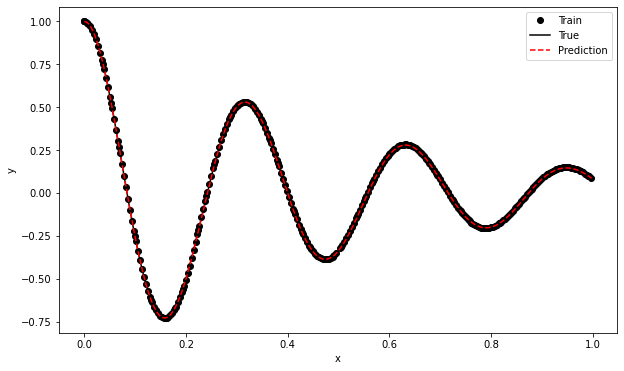

In [72]:
plot_best_state(train_state)

In [73]:
model.predict([[0.]])

array([[0.99926746]], dtype=float32)

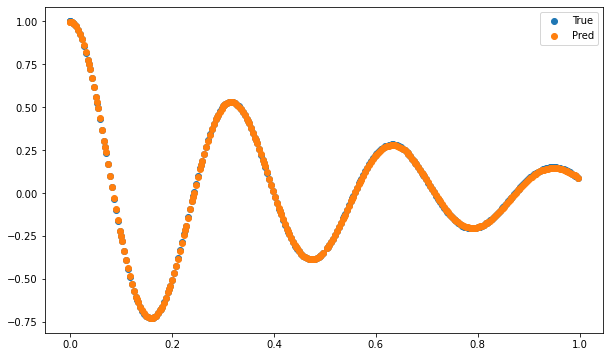

In [74]:
t_list = data.train_next_batch()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(np.array(t_list).reshape(-1,1))

plt.figure(figsize=(10, 6))
# plt.plot(t_list, true_data, "-k", label="True")
# plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

plt.scatter(t_list, true_data, label="True")
plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

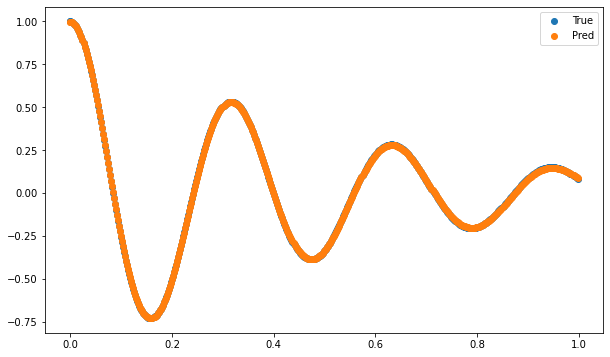

In [75]:
t_list = data.test()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(data.test()[0])

plt.figure(figsize=(10, 6))
# plt.plot(t_list, true_data, "-k", label="True")
# plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

plt.scatter(t_list, true_data, label="True")
plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

<a id="ODE1"></a>

## 周期函数

问题：
$$
\Large
\begin{cases}
\frac{dy}{dx} = \cos(x)，x\in[0,2\pi] \\
y(0) = 0\\
\end{cases}\\
$$
方程的解： $y = \sin(x)$

In [183]:
import deepxde as dde
from deepxde.backend import tf


def pde(x, y):
    dy_xx = dde.grad.jacobian(y, x)
    return dy_xx - tf.cos(x)


def boundary(_, on_initial):
    return on_initial


def func(x):
    return np.sin(x)

scale = 1  # [0., 2*pi*scale]  scale并不能无限加大,输入x = 2*pi*scale 最多只能几百。再大出nan

geom = dde.geometry.TimeDomain(0., scale*2.*np.pi)  # TimeDomain 参数不要用整数，0 容易出 nan
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
data = dde.data.PDE(geom, pde, ic1, 50*scale, 1, solution=func, num_test=100*scale)

# layer_size = [1] + [50] * 3 + [1]  # 全连接神经网络倒数第二层的神经元数量应该和采样点数量差不多
layer_size = [1,max(20,40*int(scale/10)),max(50,40*int(scale/3)),max(100,40*int(scale)),1] # 当网络只能拟合前面部分时，加宽网络
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# def inputs_transform(x):
#     return x
# net.apply_feature_transform(inputs_transform)

model = dde.Model(data, net)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "


In [184]:
net.layer_size

[1, 20, 50, 100, 1]

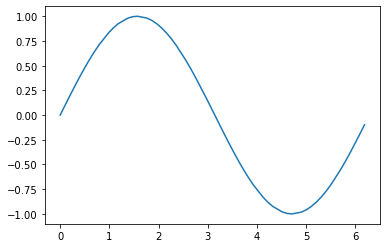

In [185]:
t = sorted(data.train_next_batch()[0])

plt.plot(t, func(t))

In [186]:
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)  # 如果 loss 为 nan，重新运行代码或者调整scale

if scale>5:
    model.compile("adam", lr=1e-4, metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.067711 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.281880 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.73e-01, 0.00e+00]    [4.89e-01, 0.00e+00]    [1.46e+00]    
1000      [1.27e-03, 4.75e-04]    [1.24e-03, 4.75e-04]    [6.18e-02]    
2000      [2.06e-04, 7.15e-12]    [2.13e-04, 7.15e-12]    [6.01e-03]    
3000      [1.37e-04, 1.48e-05]    [1.39e-04, 1.48e-05]    [9.34e-03]    
4000      [7.67e-05, 3.67e-08]    [7.66e-05, 3.67e-08]    [3.29e-03]    
5000      [2.39e-05, 3.57e-12]    [2.39e-05, 3.57e-12]    [1.65e-03]    
6000      [1.07e-05, 7.51e-07]    [1.12e-05, 7.51e-07]    [3.04e-03]    
7000      [8.26e-06, 1.05e-07]    [8.62e-06, 1.05e-07]    [8.64e-04]    
8000      [6.68e-06, 3.36e-07]    [6.99e-06, 3.36e-07]    [9.02e-04]    
9000      [5.09e-06, 5.40e-10]    [5.50e-06, 5.40e-10]    [1.13e-03]    
10000     [4.04e-06, 3.48e-11]    [4.39e-06, 3.48e-11]    [9.47e-04]    

Best model at step 10000:
  train loss: 4.04e-06
  

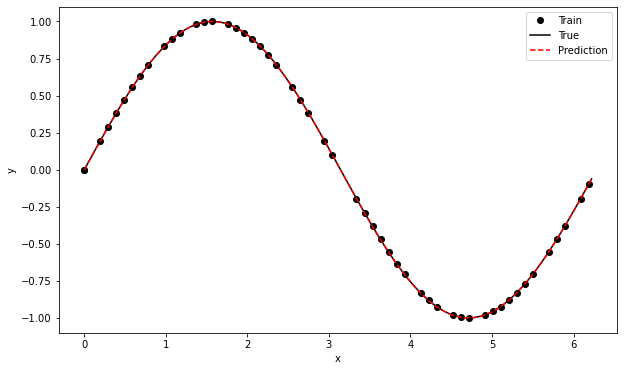

In [187]:
plot_best_state(train_state)

<a id="ODE6"></a>
## 幂函数

In [1]:
import deepxde as dde
import numpy as np


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2


def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)


def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)


def func(x):
    return (x + 1) ** 2


geom = dde.geometry.Interval(-1, 1)
bc_l = dde.icbc.DirichletBC(geom, lambda X: 0, boundary_l)
bc_r = dde.icbc.NeumannBC(geom, lambda X: 4, boundary_r)
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.055420 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+18=18. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.389746 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.01e+00, 9.81e-03, 1.67e+01]    [4.00e+00, 9.81e-03, 1.67e+01]    [1.02e+00]    
1000      [3.14e-04, 2.37e-08, 4.52e-08]    [2.91e-04, 2.37e-08, 4.52e-08]    [9.19e-04]    
2000      [5.40e-05, 1.40e-09, 2.01e-09]    [5.34e-05, 1.40e-09, 2.01e-09]    [3.80e-04]    
3000      [1.30e-05, 1.70e-09, 1.15e-09]    [1.80e-05, 1.70e-09, 1.15e-09]    [7.66e-04]    
4000      [1.04e-05, 7.76e-11, 3.27e-11]    [1.58e-05, 7.76e-11, 3.27e-11]    [7.53e-04]    
5000      [8.87e-06, 1.05e-10, 1.10e-10]    [1.38e-05, 1.05e-10, 1.10e-10]    [6.92e-04]    
6000      [7.70e-06, 5.15e-07, 6.06e-07]    [1.15e-05, 5.15e-07, 6.06e-07]    [5.65e-04]    
7000      [6.19e-06, 2.96e-13, 1.46e-11]    [9.91e-06, 2.96e-13, 1.46e-11]    [5.72e-04]    
8000      [6.74e-06, 6.45e-06, 7.88e-06]    [8.37e-06, 6.45e-06, 7.88e-06]    [7.79e-04]   

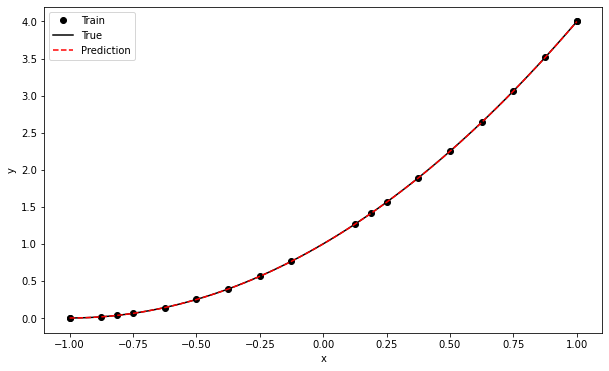

In [4]:
plot_best_state(train_state)

In [7]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

m = 1.
delta = 2.
omega_0 = 20.

mu = 2*m*delta
k = m*omega_0*omega_0
omega = np.sqrt(omega_0**2-delta**2)
phi = np.arctan(-delta/omega)
A = 1/(2*np.cos(phi))



def pde(t, x):
    dx_t = dde.grad.jacobian(x, t)
    dx_tt = dde.grad.hessian(x, t)
    # return m*dx_tt - mu*dx_t + k*x
    return dx_tt - mu/m*dx_t + k/m*x


def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def func(t):
    # omega = np.sqrt(omega_0**2-delta**2)
    # phi = np.arctan(-delta/omega)
    # A = 1/(2*np.cos(phi))
    return np.exp(-delta*t)*2*A*np.cos(omega*t+phi)

scale = 1  # [0, 1*scale]

geom = dde.geometry.TimeDomain(0., scale*1)
ic1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.
ic_2 = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0., boundary, component=0) # 导数条件 dx(0)/dt = 0

# ic_2 = dde.icbc.OperatorBC(
#     geom,
#     lambda x, y, _: dde.grad.jacobian(y, x),
#     boundary,
# ) # 导数条件 dx(0)/dt = 0

# ic_2 = dde.icbc.OperatorBC(
#     geom,
#     lambda x, y, _: dde.grad.jacobian(y, x) - 0.0,
#     lambda x, _: np.isclose(x, 0),
# ) # 导数条件 dx(0)/dt = 0

# observe_x = geom.uniform_points(50)
# # bc_init = dde.icbc.boundary_conditions.PointSetBC(points=np.array([[0.]]), values=np.array([[1.]]), component=0)
# observe_y = dde.icbc.boundary_conditions.PointSetBC(points=observe_x, values=func(observe_x), component=0)

data = dde.data.PDE(geom, pde, [ic1, ic_2], 30*scale, 1, solution=func, num_test=50*scale)

layer_size = [1] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [8]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights = [1, 1, 1])
losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.062692 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.459026 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.74e+03, 1.00e+00, 8.43e-02]    [3.86e+03, 1.00e+00, 8.43e-02]    [1.07e+00]    
1000      [2.26e-02, 1.00e+00, 1.13e-05]    [2.26e-02, 1.00e+00, 1.13e-05]    [1.00e+00]    
2000      [1.81e-02, 1.00e+00, 9.03e-06]    [1.82e-02, 1.00e+00, 9.03e-06]    [1.00e+00]    
3000      [1.24e-02, 1.00e+00, 6.14e-06]    [1.24e-02, 1.00e+00, 6.14e-06]    [1.00e+00]    
4000      [6.55e-03, 1.00e+00, 3.24e-06]    [6.58e-03, 1.00e+00, 3.24e-06]    [1.00e+00]    
5000      [2.33e-03, 1.00e+00, 1.13e-06]    [2.35e-03, 1.00e+00, 1.13e-06]    [1.00e+00]    
6000      [4.21e-04, 1.00e+00, 1.89e-07]    [4.31e-04, 1.00e+00, 1.89e-07]    [1.00e+00]    
7000      [4.05e-05, 1.00e+00, 2.91e-09]    [4.16e-05, 1.00e+00, 2.91e-09]    [1.00e+00]    
8000      [4.28e-05, 1.00e+00, 6.15e-09]    [4.03e-05, 1.00e+00, 6.15e-09]    [1.00e+00]   

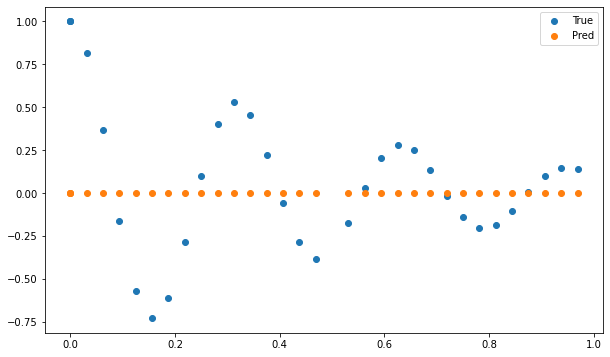

In [11]:
t_list = data.train_next_batch()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(data.train_next_batch()[0])

plt.figure(figsize=(10, 6))
# plt.plot(t_list, true_data, "-k", label="True")
# plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

plt.scatter(t_list, true_data, label="True")
plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

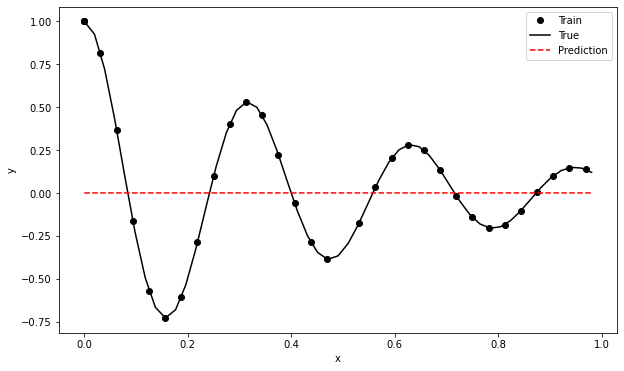

In [12]:
plot_best_state(train_state)

In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

m = 1.
delta = 2.
omega_0 = 20.

mu = 2*m*delta
k = m*omega_0*omega_0
omega = np.sqrt(omega_0**2-delta**2)
phi = np.arctan(-delta/omega)
A = 1/(2*np.cos(phi))



def pde(t, x):
    dx_t = dde.grad.jacobian(x, t)
    dx_tt = dde.grad.hessian(x, t)
    # return m*dx_tt - mu*dx_t + k*x
    return dx_tt - mu/m*dx_t + k/m*x


def boundary(x, on_boundary):
    return on_boundary

# def boundary(x, on_boundary):
#     return on_boundary and np.isclose(x[0], 0.)

def func(t):
    # omega = np.sqrt(omega_0**2-delta**2)
    # phi = np.arctan(-delta/omega)
    # A = 1/(2*np.cos(phi))
    return np.exp(-delta*t)*2*A*np.cos(omega*t+phi)

scale = 1  # [0, 2*pi*scale]

geom = dde.geometry.TimeDomain(0., scale*1.)
ic1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.


# def dydx(x, y): 
#     return dde.grad.jacobian(y, x, i=0, j=0)

# ic_2 = dde.icbc.OperatorBC(
#        geom,
#        lambda x, y, _: np.isclose(dydx(x, y), 0.),
#        boundary)

ic_2 = dde.icbc.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x) - 0.0,
    lambda x, _: np.isclose(x, 0),
)


observe_x = geom.uniform_points(50)

# bc_init = dde.icbc.boundary_conditions.PointSetBC(points=np.array([[0.]]), values=np.array([[1.]]), component=0)
observe_y = dde.icbc.boundary_conditions.PointSetBC(points=observe_x, values=func(observe_x), component=0)

data = dde.data.PDE(geom, pde, [ic1, ic_2, observe_y], 50*scale, 1, solution=func, num_test=100*scale)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "


In [34]:
data.train_next_batch()[0].shape

(103, 1)

In [54]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights = [1e-4, 1000, 1e-4, 1000])
losshistory, train_state = model.train(epochs=10000)

Compiling model...
'compile' took 0.528506 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
70000     [2.36e-03, 5.35e+00, 1.72e-04, 1.19e+01]    [7.85e+00, 5.35e+00, 1.72e-04, 1.19e+01]    [2.91e-01]    
71000     [1.08e-01, 1.71e-02, 2.40e-04, 6.53e-02]    [4.57e+00, 1.71e-02, 2.40e-04, 6.53e-02]    [2.60e-02]    
72000     [1.01e-01, 8.64e-03, 2.66e-04, 6.04e-02]    [3.74e+00, 8.64e-03, 2.66e-04, 6.04e-02]    [2.45e-02]    
73000     [1.02e-01, 1.64e-04, 2.79e-04, 4.93e-02]    [3.67e+00, 1.64e-04, 2.79e-04, 4.93e-02]    [2.25e-02]    
74000     [1.01e-01, 4.41e-04, 2.99e-04, 4.75e-02]    [4.04e+00, 4.41e-04, 2.99e-04, 4.75e-02]    [2.23e-02]    
75000     [9.94e-02, 1.69e-05, 3.11e-04, 4.76e-02]    [4.78e+00, 1.69e-05, 3.11e-04, 4.76e-02]    [2.28e-02]    
76000     [9.87e-02, 4.14e-08, 3.28e-04, 4.65e-02]    [5.51e+00, 4.46e-08, 3.28e-04, 4.65e-02]    [2.32e-02]    
77000     [9.31e-02, 8.52e-02, 

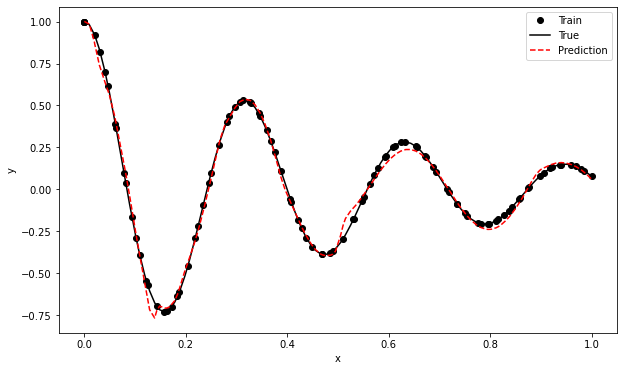

In [56]:
plot_best_state(train_state)

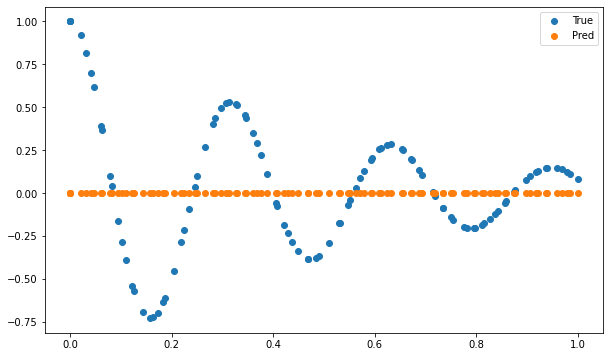

In [31]:
t_list = data.train_next_batch()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(data.train_next_batch()[0])

plt.figure(figsize=(10, 6))
# plt.plot(t_list, true_data, "-k", label="True")
# plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

plt.scatter(t_list, true_data, label="True")
plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

## 学到更多

求解一个 Lotka-Volterra 方程：https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/lotka.volterra.html

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward.html#odes